In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.preprocessing import StandardScaler

import torch
import torch_geometric
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.models.nn_layers import MLPModel
from src.models.gnn_layers import MyGATConv
from src.models.ML_frameworks import GNNFramework
import src.loading as loading
import src.processing as processing

from src.visualization.analyse_model import plot_errors_labels_comparison

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
## Data


data = loading.load_data()

def nor_function(a,b):
    return (a or b) and not(a and b)

data["NoExp_Exp"] = data.apply(lambda row: nor_function(row["word1_experience"]>50,row["word2_experience"]>50),axis=1)

scaler = StandardScaler()
data.loc[:,["word1_sc_liking","word2_sc_liking","sc_senenceBERT_mpnet_similarity","sc_depressionCont","sc_NoExp_Exp"]] = scaler.fit_transform(data.loc[:,["word1_liking","word2_liking","senenceBERT_mpnet_similarity","depressionCont","NoExp_Exp"]])
data.loc[:,["word1_sc_liking","word2_sc_liking","sc_senenceBERT_mpnet_similarity","sc_depressionCont","sc_NoExp_Exp"]]


== Load Data: start ==
== Load Data: end ==


,word1_sc_liking,word2_sc_liking,sc_senenceBERT_mpnet_similarity,sc_depressionCont,sc_NoExp_Exp
0,-1.172222,-1.152427,1.118413,-0.229448,-0.891164
1,-1.172222,0.605846,-0.021906,-0.229448,-0.891164
2,-1.172222,0.546244,0.867681,-0.229448,1.122128
3,-1.172222,-0.019980,1.244298,-0.229448,-0.891164
4,-1.172222,0.456840,0.193088,-0.229448,-0.891164
...,...,...,...,...,...
198235,0.456083,0.546244,0.040509,-0.708297,1.122128
198236,0.456083,1.201871,-0.668605,-0.708297,1.122128
198237,0.394638,0.546244,-1.800021,-0.708297,1.122128
198238,0.394638,1.201871,-0.165669,-0.708297,1.122128


In [4]:
data.columns.tolist()

['word_pair',
 'rated_similarity',
 'abs_liking_diference',
 'word1_liking',
 'word2_liking',
 'word1_experience',
 'word2_experience',
 'depression',
 'depressionCont',
 'female',
 'age',
 'participant',
 'senenceBERT_mpnet_similarity',
 'senenceBERT_miniLM_similarity',
 'sense2vec_similarity',
 'gptLarge_similarity',
 'word1',
 'word2',
 'NoExp_Exp',
 'word1_sc_liking',
 'word2_sc_liking',
 'sc_senenceBERT_mpnet_similarity',
 'sc_depressionCont',
 'sc_NoExp_Exp']

In [5]:
node_table = processing.build_node_table(data,["liking"],distinct_id=["participant"])
scaler_liking = StandardScaler()
scaler_liking.fit(node_table.liking.to_numpy()[...,np.newaxis])

/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word2.rename(columns=col_renaming,inplace=True)


StandardScaler()

In [6]:
subdata = data[data["participant"] == 3]

subdata["rnd_sim"] = np.ones(len(subdata))

participant_graph,translator_word_to_index = processing.convert_table_to_graph(
    complete_data_table=subdata,
    node_attr_names=["liking"],
    node_label_names=["liking"],
    edge_attr_names=["rnd_sim"],
    return_word_to_index=True)

scaler_x = StandardScaler()
participant_graph.x = scaler_liking.transform(participant_graph.x)
transformed_50 = scaler_liking.transform(np.array([[50]]))
participant_graph.x -= np.repeat(transformed_50,repeats=participant_graph.num_nodes,axis=0)
participant_graph.x = torch.Tensor(participant_graph.x)

# if same features as x, will give the same values anyway
scaler_y = StandardScaler() 
participant_graph.y = scaler_liking.transform(participant_graph.y)
transformed_50 = scaler_liking.transform(np.array([[50]]))
participant_graph.y -= np.repeat(transformed_50,repeats=participant_graph.num_nodes,axis=0)
participant_graph.y = torch.Tensor(participant_graph.y)

print("participant_graph:",participant_graph)
print("participant_graph.x:",participant_graph.x)
print("participant_graph.edge_attr:",participant_graph.edge_attr)
print("participant_graph.y:",participant_graph.y)

Test function convert_table_to_graph
Data(x=[60, 1], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], train_mask=[60], val_mask=[60])
validate: True
is undirected: True
has_self_loop: tensor(False)
end Test function convert_table_to_graph
participant_graph: Data(x=[60, 1], edge_index=[2, 3540], edge_attr=[3540, 1], y=[60, 1], train_mask=[60], val_mask=[60])
participant_graph.x: tensor([[ 1.5125],
        [ 1.5125],
        [ 1.5125],
        [ 0.9680],
        [-0.0908],
        [ 0.4840],
        [ 0.8773],
        [ 1.5125],
        [ 1.0890],
        [-0.4538],
        [ 0.7865],
        [ 1.5125],
        [-1.5125],
        [ 1.5125],
        [ 0.9983],
        [ 1.2705],
        [-0.5748],
        [ 0.3328],
        [ 1.5125],
        [ 0.0000],
        [ 0.7260],
        [ 0.0000],
        [-0.7563],
        [ 1.5125],
        [ 0.4235],
        [ 0.4840],
        [-0.0303],
        [ 0.5748],
        [-0.4235],
        [ 1.5125],
        [ 1.5125],
        [ 1.4823],
      

/tmp/ipykernel_5238/364314989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdata["rnd_sim"] = np.ones(len(subdata))
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extracted_features_word1.rename(columns=col_renaming,inplace=True)
/home/julien-rsbrg/Documents/UCL/SemanticToLiking/src/processing.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [66]:
## Model

#my_module = MLPModel(c_in=1, c_hidden=5, c_out=1,num_layers=2,dp_rate=0.0)

src_content_mask = torch.Tensor([True]).to(torch.bool)
src_edge_mask = torch.Tensor([False]).to(torch.bool)
dst_mask = torch.Tensor([False]).to(torch.bool)
my_module = myGATConv(
    in_channels=(1,1),
    out_channels=1,
    heads=1,
    negative_slope=0.0,
    add_self_loops=False,
    edge_dim=1,
    dropout=0.0,
    src_content_mask=src_content_mask,
    src_edge_mask=src_edge_mask,
    dst_content_mask=dst_mask,
    dst_edge_mask=dst_mask)

print(my_module.lin_src)

"""
my_module = torch_geometric.nn.GATConv(
    in_channels=(1,1),
    out_channels=1,
    heads=1,
    negative_slope=0.0,
    add_self_loops=False,
    edge_dim=1,
    dropout=0.0)


my_module = torch_geometric.nn.GCNConv(
    in_channels=1, 
    out_channels=1
    )
"""

# my_module(x=participant_graph.x,edge_index=participant_graph.edge_index,edge_attr=participant_graph.edge_attr)
print(my_module)
print([param for param in my_module.parameters()])

## Training
complete_model = GNN_naive_framework(my_module,device)

if False:
    opt = complete_model.configure_optimizer(lr=0.1)
    scheduler = complete_model.configure_scheduler(opt,0.1,0.1,10)

    history = complete_model.train([participant_graph],10000,1,opt,scheduler,"train_loss",200)

## Visualization
plot_errors_labels_comparison(complete_model,participant_graph,True)

Linear(1, 1, bias=False)
myGATConv((1, 1), 1, heads=1)
[Parameter containing:
tensor([[[1.5664]]], requires_grad=True), Parameter containing:
tensor([[[-0.1124]]], requires_grad=True), Parameter containing:
tensor([[[0.1322]]], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor([[0.5847]], requires_grad=True), Parameter containing:
tensor([[1.3645]], requires_grad=True), Parameter containing:
tensor([[1.4299]], requires_grad=True), <UninitializedParameter>, <UninitializedParameter>, Parameter containing:
tensor([[1.5865]], requires_grad=True), <UninitializedParameter>]


[autoreload of src.models.gnn_layers failed: Traceback (most recent call last):
  File "/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/julien-rsbrg/venv/venv_

labels= [ 1.5125272   1.5125272   1.5125272   0.9680174  -0.09075163  0.4840087
  0.87726575  1.5125272   1.0890195  -0.45375815  0.78651416  1.5125272
 -1.5125272   1.5125272   0.99826795  1.2705228  -0.5747603   0.33275598
  1.5125272   0.          0.72601306  0.         -0.7562636   1.5125272
  0.4235076   0.4840087  -0.03025054  0.5747603  -0.4235076   1.5125272
  1.5125272   1.4822767  -0.09075163  1.5125272   1.5125272   1.5125272
 -0.81676465  1.4822767   1.5125272   0.         -1.5125272   1.5125272
  1.5125272   0.24200435  1.5125272   1.0890195   0.87726575  0.06050109
  1.058769    1.5125272   1.5125272  -0.15125272  0.6957625   1.0285184
  1.1192701   1.5125272   1.5125272   1.5125272   1.5125272   1.5125272 ]
preds= [1.2510968 1.2510965 1.2510968 1.2657391 1.2942101 1.2787545 1.2681794
 1.2510966 1.2624851 1.3039716 1.2706198 1.2510966 1.3324426 1.2510967
 1.2649256 1.2576042 1.3072251 1.2828213 1.2510965 1.2917693 1.2722464
 1.2917697 1.312106  1.2510966 1.2803811 1.27875

In [67]:
complete_model.update_node_module.get_description_parameters()

,src_content_0,att_src_edge_0,src_edge_0,full_src_edge_0,dst_content_0,att_dst_edge_0,dst_edge_0,full_dst_edge_0,att_edge_0,edge_0,full_edge_0,bias_0
0,1.586548,1.566436,None,None,None,-0.112365,None,None,0.132171,1.429921,0.188995,0.0


In [22]:
parameters_spec = {}
L_params = list([param for param in complete_model.update_node_module.lin_content_src.parameters()][0].squeeze())

if len(L_params) > 1:
    for param_id, param in enumerate(L_params):
        parameters_spec[f"lin_content_src_{param_id:d}"] = [float(param.detach().cpu())]
else:
    parameters_spec[f"lin_content_src"] = [float(L_params[0].detach().cpu())]

import pandas as pd
pd.DataFrame(parameters_spec)

,lin_content_src_0,lin_content_src_1
0,-1.695836,0.002164


In [24]:
torch.nn.init.ones_(complete_model.update_node_module.lin_src.weight)

complete_model.update_node_module.lin_src.weight

Parameter containing:
tensor([[1.]], device='cuda:0', requires_grad=True)

In [64]:
def create_dummy_graph(num_nodes: int,
                       x_dim: int,
                       edge_attr_dim: int,
                       y_dim: int,
                       ratio_known: float = 0.5,
                       ratio_edges_kept: float = 0.5):
    assert ratio_known > 0 and ratio_known < 1

    # edges 
    edge_index = torch.Tensor(np.meshgrid(np.arange(num_nodes),np.arange(num_nodes))).reshape((2,-1)).to(torch.int64)
    is_self_loop = edge_index.sum(dim=0) < 0.5
    print("size =",is_self_loop.size())
    print("size edge_index=",edge_index.size())

    edge_index = edge_index[...,~is_self_loop]
    num_edges = edge_index.size(1)
    edge_attr = torch.normal(mean=torch.zeros((num_edges,edge_attr_dim)), std=torch.ones((num_edges,edge_attr_dim)))

    # remove some edges
    p = 1/num_edges*torch.ones(num_edges)
    num_edges_kept = max(int(ratio_edges_kept*num_edges),1)
    idx_edges_kept = p.multinomial(num_samples=num_edges_kept, replacement=False)
    edge_index = edge_index[:,idx_edges_kept]
    edge_attr = edge_attr[idx_edges_kept,:]

    # nodes
    x = torch.normal(mean=torch.zeros((num_nodes,x_dim)), std=torch.ones((num_nodes,x_dim)))
    # tag the nodes that the model can infer from
    p = 1/num_nodes*torch.ones(num_nodes)
    num_known = max(int(ratio_known*num_nodes),1)

    idx_known = p.multinomial(num_samples=num_known, replacement=False)
    x[idx_known,-1] = torch.ones(num_known)
 
    data_graph = torch_geometric.data.Data(
        x = x, 
        edge_index = edge_index,
        edge_attr = edge_attr, 
        y = x[...,:y_dim], 
        train_mask = x[...,-1] == 1, 
        val_mask = x[...,-1] == 0
        )
    print("data_graph:",data_graph)
    print("x",x)
    print("edge_attr",edge_attr)
    
    # create the model
    my_module = myGATConv(
        in_channels=(x_dim,x_dim),
        out_channels=1,
        heads=1,
        negative_slope=0.0,
        add_self_loops=False,
        edge_dim=1,
        dropout=0.0,
        src_mask=src_mask,
        dst_mask=dst_mask
        )
    complete_model = GNN_naive_framework(
        my_module,
        device,
        mask_node_fn = lambda x: x[...,-1] == 1)
    

    new_x = complete_model.predict(data_graph.x,edge_index=data_graph.edge_index,edge_attr=data_graph.edge_attr)
    x[x[...,-1]==0,0] = new_x[x[...,-1]==0,0]
    data_graph = torch_geometric.data.Data(
        x = x, 
        edge_index = data_graph.edge_index,
        edge_attr = data_graph.edge_attr, 
        y = x[...,:y_dim], 
        train_mask = x[...,-1] == 1, 
        val_mask = x[...,-1] == 0
    )

    return data_graph

create_dummy_graph(
    num_nodes=3,
    x_dim=1,
    edge_attr_dim=1,
    y_dim=1,
    ratio_edges_kept=0.3)

size = torch.Size([9])
size edge_index= torch.Size([2, 9])
data_graph: Data(x=[3, 1], edge_index=[2, 2], edge_attr=[2, 1], y=[3, 1], train_mask=[3], val_mask=[3])
x tensor([[ 1.0000],
        [ 0.8321],
        [-1.3477]])
edge_attr tensor([[ 0.3915],
        [-0.5129]])
mask_samples,mask_attr tensor([True, True, True], device='cuda:0') tensor([True], device='cuda:0')


RuntimeError: numel: integer multiplication overflow

TODO: shift between device

print(a.cpu()[b.cpu(),:])

print(a.cuda()[b.cuda(), :])

In [71]:
A = torch.Tensor([[0,1,2,2.5],
                  [3,4,5,6]])
print(A.size())

mask_samples,mask_attr = torch.Tensor([True, True, True,False]).to(dtype=torch.bool), torch.Tensor([True,False]).to(dtype=torch.bool)

print(mask_samples.dtype)
A[mask_attr,mask_samples]

torch.Size([2, 4])
torch.bool


tensor([0., 1., 2.])

In [32]:
a = torch.tensor([1, 2, 3, 4])
p = torch.tensor([0.1, 0.1, 0.1, 0.7])
n = 2
replace = False

idx = p.multinomial(num_samples=n, replacement=replace)
b = a[idx]
b
print(idx)

tensor([1, 3])


In [8]:
torch.Tensor([[0,2,3],[1,2,3]]).sum(dim=0)

tensor([1., 4., 6.])

In [6]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objects as go
from typing import Optional, Iterable

def convert_float_to_hsl(l,min_l,max_l,s=100,h=235):
    if max_l < min_l:
        min_l, max_l = max_l, min_l
        print("Careful: min max lighting exchanged")

    if max_l != min_l:
        scaled_l = (l-min_l)/(max_l-min_l)*100
        scaled_l = min(int(scaled_l),90)
    else:
        scaled_l = 90
    
    return f"hsl({h:d},{s:d}%,{scaled_l:d}%)"


def convert_torch_to_networkx_graph(data: torch_geometric.data.Data, edge_attr_id: int = 0, to_undirected:bool|str = False):
    G = to_networkx(data, to_undirected=to_undirected)
    weights = {e_pair:float(data.edge_attr[e,edge_attr_id]) for e,e_pair in enumerate(G.edges())} 
    nx.set_edge_attributes(G, values = weights, name = 'weight')
    return G

def draw_torch_graph(data: torch_geometric.data.Data, 
               node_annotations: Optional[Iterable] = None,
               node_colors: Optional[Iterable] = None,
               node_color_label: Optional[str] = "",
               title: Optional[str] = ""):
    G = convert_torch_to_networkx_graph(data=data)
    draw_networkx_graph(G,
                        node_annotations=node_annotations,
                        node_colors=node_colors,
                        node_color_label=node_color_label,
                        title=title)

def draw_networkx_graph(
        G: nx.Graph, 
        node_annotations: Optional[Iterable] = None,
        node_colors: Optional[Iterable] = None,
        node_color_label: Optional[str] = "",
        title: Optional[str] = ""):
    
    # adapts: https://plotly.com/python/network-graphs/
    pos = nx.spring_layout(G, k=20*1/np.sqrt(G.number_of_nodes()), weight="weight",seed = 50, iterations=500)


    edge_attr = list(nx.get_edge_attributes(G,"weight").values())
    min_edge_attr,max_edge_attr = np.min(edge_attr),np.max(edge_attr)
    
    edge_traces = []
    for edge in G.edges():
        edge_x = []
        edge_y = []
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_y.append(y0)
        edge_y.append(y1)

        color = convert_float_to_hsl(float(G.get_edge_data(edge[0],edge[1])["weight"]),min_edge_attr,max_edge_attr)
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5,color=color),
            hoverinfo='none', #to change
            mode='lines'
        )
        edge_traces.append(edge_trace)
    

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=node_colors,
            size=10,
            colorbar=dict(
                thickness=15,
                title=dict(
                    text=node_color_label, # to change
                    side='right'
                ),
                xanchor='left',
            ),
            line_width=2))
    
    # colors
    node_text = []
    for node in G.nodes():
        # node_adjacencies.append(len(adjacencies[1]))
        node_text.append(str(node_annotations[node])+f":{node_colors[node]:.2f}")

    # node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    # plot
    fig = go.Figure(data=edge_traces+[node_trace],
             layout=go.Layout(
                title=dict(
                    text=title,
                    font=dict(
                        size=16
                    )
                ),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
    fig.show()

participant_id = 3 # should be before when create participant graph
draw_torch_graph(participant_graph,
           node_annotations=list(translator_word_to_index.keys()),
           node_colors = participant_graph.x[:,0].tolist(),
           node_color_label="Liking for activity",
           title=f"Semantic network of activities with liking for participant {participant_id}")

In [21]:
participant_graph.edge_attr[0,0]

tensor(0.3758)

In [7]:
def add_invert_edge_attr(G:nx.Graph,edge_attr_name:str,new_edge_attr_name:str):
    new_G = G.copy()
    edge_attr = nx.get_edge_attributes(new_G,name=edge_attr_name)
    new_edge_attr = {k:1/(v+1e-6) for k,v in edge_attr.items()}
    nx.set_edge_attributes(new_G, values = new_edge_attr, name = new_edge_attr_name)
    return new_G

def add_opposite_edge_attr(G:nx.Graph,edge_attr_name:str,new_edge_attr_name:str):
    new_G = G.copy() 
    edge_attr = nx.get_edge_attributes(new_G,name=edge_attr_name)
    new_edge_attr = {k:-v for k,v in edge_attr.items()}
    nx.set_edge_attributes(G, values = new_edge_attr, name = new_edge_attr_name)
    return new_G

In [8]:
G_participant_graph = convert_torch_to_networkx_graph(participant_graph,to_undirected="upper")

In [10]:
def cluster_nodes(G:nx.Graph, opposite_weight:bool = False, upper_quantile_removed:float=.8):
    """
    Cluster nodes with Kruskal's algorithm. 
    The greater the weight the less likely the two nodes are in the same component.
    """
    edge_attr_name = "weight" 
    if opposite_weight:
        new_G = add_opposite_edge_attr(G,"weight","opposite_weight")
        edge_attr_name = "opposite_weight"

    G_MST = nx.minimum_spanning_tree(new_G, weight=edge_attr_name)

    opposite_weight = list(nx.get_edge_attributes(G_MST,name=edge_attr_name).values())
    print("opposite_weight:",opposite_weight)

    q = np.quantile(opposite_weight,upper_quantile_removed)
    for edge,edge_opp_weight in nx.get_edge_attributes(G_MST,edge_attr_name).items():
        if edge_opp_weight >= q:
            G_MST.remove_edge(edge[0],edge[1])

    connected_components_index = sorted(nx.connected_components(G_MST), key=len, reverse=True)
    return connected_components_index, G_MST

def draw_clustering(G:nx.Graph,
                    opposite_weight: bool = True,
                    upper_quantile_removed:float=0.8,
                    node_annotations: Optional[Iterable] = None,
                    node_colors: Optional[Iterable] = None,
                    node_color_label: Optional[str] = ""):
    connected_components_index, G_MST = cluster_nodes(G, opposite_weight = opposite_weight, upper_quantile_removed = upper_quantile_removed)

    words = list(translator_word_to_index.keys())
    for nodes_index in connected_components_index:
        new_component_words = []
        for id in nodes_index:
            new_component_words.append(words[id])
        print("Component's words =", new_component_words)

        n_nodes = len(nodes_index)
        if n_nodes > 1: 
            component_subgraph = G_MST.subgraph(nodes_index)
            weights = list(nx.get_edge_attributes(component_subgraph,"weight").values())
            weight_message = f"min weight = {np.min(weights):.3f}, max weights = {np.max(weights):.3f}"

            draw_networkx_graph(
                component_subgraph,
                node_annotations=node_annotations,
                node_colors = node_colors,
                node_color_label = node_color_label,
                title=f"Component with {n_nodes:d} nodes ("+ weight_message +")")

draw_clustering(G_participant_graph,
                upper_quantile_removed=.7,
                node_annotations=list(translator_word_to_index.keys()),
                node_colors = participant_graph.x[:,0].tolist(),
                node_color_label = "Activity liking")

opposite_weight: [-0.6847240924835205, -0.6759021282196045, -0.632486879825592, -0.6764088273048401, -0.5106438994407654, -0.6570445895195007, -0.5975801944732666, -0.5737650990486145, -0.5634975433349609, -0.5439391136169434, -0.4620085060596466, -0.6007193326950073, -0.5379036068916321, -0.5753970146179199, -0.44333285093307495, -0.5617233514785767, -0.5179885625839233, -0.5022070407867432, -0.4734629988670349, -0.5635277032852173, -0.4974006116390228, -0.4168514907360077, -0.7419806718826294, -0.6779348850250244, -0.5500592589378357, -0.6734994649887085, -0.47571882605552673, -0.6199549436569214, -0.5055979490280151, -0.4942592680454254, -0.4823797941207886, -0.40419742465019226, -0.633335292339325, -0.5652564764022827, -0.5814584493637085, -0.48360520601272583, -0.5089654326438904, -0.559266984462738, -0.5155819654464722, -0.5013588666915894, -0.5539641380310059, -0.5451801419258118, -0.5239359140396118, -0.6200007796287537, -0.5455960035324097, -0.49847373366355896, -0.49035382270

Component's words = ['Art gallery', 'Museum', 'Painting', 'Pottery workshop', 'Gardening', 'Historical tour', 'Home decorating']


Component's words = ['Board games', 'Online chess', 'Poker', 'Sports video games', 'Frisbee']


Component's words = ['Book club', 'Clubbing', 'Pub or bar', 'Farmers market', 'Local restaurant']


Component's words = ['Walk in the park', 'Indoor rock climbing', 'Running outside', 'Hiking']


Component's words = ['Meal prepping', 'Baking cookies', 'Bread making']


Component's words = ['Computer programming', 'Creative writing']


Component's words = ['Chat online']
Component's words = ['Clothes shopping']
Component's words = ['DIY']
Component's words = ['Knitting']
Component's words = ['Lift weights']
Component's words = ['News articles']
Component's words = ['Play football']
Component's words = ['Practice an instrument']
Component's words = ['Salsa class']
Component's words = ['Spin class']
Component's words = ['Spotify playlist']
Component's words = ['YouTube videos']


In [71]:
def balance_nrows_ncols(n):
    nrows,ncols = 0, 0
    for i in range(n):
        nrows += i%2
        ncols += (i+1)%2
    return nrows,ncols

balance_nrows_ncols(15)

(7, 8)

In [73]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
import pandas as pd

mock_data = np.random.randn((500,5))
mock_data = pd.DataFrame(mock_data)

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Histogram(x=x0,name="Fred",legendgroup="Friend",legendgrouptitle={"text":"Friend"}),row=1,col=1)
fig.add_trace(go.Histogram(x=x1,name="Carl",legendgroup="Enemy"),row=1,col=1)

fig.add_trace(go.Histogram(x=x1,name="Carl",legendgroup="Friend"),row=1,col=2)

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

TypeError: 'tuple' object cannot be interpreted as an integer

In [82]:
import pandas as pd
from typing import Optional, Iterable


mock_data = np.random.randn(500,5)
mock_data = pd.DataFrame(mock_data)
mock_data.head()

def plot_histograms(data:pd.DataFrame, 
                    vars_names:Optional[Iterable[str]] = None, 
                    mask:Optional[np.ndarray] = None,
                    mask_legend: Optional[str] = "selected by mask",
                    title: Optional[str] = ""):
    if vars_names is None:
        vars_names = data.columns.tolist()
    if mask is None:
        mask = np.ones(len(data),dtype=bool)

    nvars = len(vars_names) 
    nrows,ncols = balance_nrows_ncols(nvars)

    fig = make_subplots(rows=nrows, 
                        cols=ncols, 
                        subplot_titles=[str(v) for v in vars_names],
                        vertical_spacing = 0.3,
                        horizontal_spacing = 0.1)

    data_mask_selected = data[mask]
    data_not_mask_selected = data[~mask]
    for col_id, col_name in enumerate(vars_names):
        row,col = col_id%nrows + 1, col_id//nrows + 1, 
        
        fig.add_trace(go.Histogram(x=data_mask_selected[col_name],
                                   name="",
                                   legendgroup=mask_legend,
                                   legendgrouptitle={"text":mask_legend},
                                   showlegend=col_id == 0,
                                   marker_color="#3dc244"),
                                   row=row,col=col)
        fig.add_trace(go.Histogram(x=data_not_mask_selected[col_name],
                                   name="",
                                   legendgroup="not("+mask_legend+")",
                                   legendgrouptitle={"text":"not("+mask_legend+")"},
                                   showlegend=col_id == 0,
                                   marker_color='#cf0c1c'),
                                   row=row,col=col)
        fig.add_trace(go.Histogram(x=data[col_name],
                                   name="",
                                   legendgroup="all samples",
                                   legendgrouptitle={"text":"all samples"},
                                   showlegend=col_id == 0,
                                   marker_color="#1331f6"),
                                   row=row,col=col)
        
        
        fig['layout'][f'xaxis{col_id+1:d}']['title']='value'
        fig['layout'][f'yaxis{col_id+1:d}']['title']='count'


    # Overlay both histograms
    fig.update_layout(barmode='group', title=title)
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=0.9)
    fig.show()

mock_mask = np.ones(len(mock_data),dtype=bool)
mock_mask[-len(mock_data)//3:] = False
plot_histograms(mock_data,mask=mock_mask,title="Title")

In [88]:
def plot_violins(data:pd.DataFrame, 
                 vars_names:Optional[Iterable[str]] = None, 
                 mask:Optional[np.ndarray] = None,
                 mask_legend: Optional[str] = "selected by mask",
                 title: Optional[str] = ""):
    if vars_names is None:
        vars_names = data.columns.tolist()
    if mask is None:
        mask = np.ones(len(data),dtype=bool)

    nvars = len(vars_names) 

    fig = make_subplots(rows=1, 
                        cols=nvars, 
                        subplot_titles=[str(v) for v in vars_names],
                        vertical_spacing = 0.3,
                        horizontal_spacing = 0.1)

    data_mask_selected = data[mask]
    data_not_mask_selected = data[~mask]
    for col_id, col_name in enumerate(vars_names):
        row,col = 1, col_id+1 
        
        fig.add_trace(go.Violin(y=data_mask_selected[col_name],
                                name="",
                                legendgroup=mask_legend, 
                                legendgrouptitle={"text":mask_legend},
                                side='negative',
                                pointpos=-0.8, # where to position points
                                line_color="#3dc244",
                                showlegend=col_id == 0),
                                row=row,col=col)
        fig.add_trace(go.Violin(y=data_not_mask_selected[col_name],
                                name="",
                                legendgroup="not("+mask_legend+")", 
                                legendgrouptitle={"text":"not("+mask_legend+")"},
                                side='positive',
                                pointpos=0.8, # where to position points
                                line_color="#cf0c1c",
                                showlegend=col_id == 0),
                                row=row,col=col)


    # Overlay both histograms
    fig.update_layout(barmode='group', title=title)
    # Reduce opacity to see both histograms
    fig.update_traces(opacity=0.9)
    fig.show()

mock_mask = np.ones(len(mock_data),dtype=bool)
mock_mask[-len(mock_data)//3:] = False
plot_violins(mock_data,mask=mock_mask,title="Title")

In [63]:
dico = {3:[0,1],4:[4,3]}
pd.DataFrame(dico)

,3,4
0,0,4
1,1,3


In [2]:
import pandas as pd
import numpy as np

data = pd.DataFrame(data = {"a":[0,1,2,3],"b":[5,6,7,8]})
print(data)
np.linalg.norm(data.iloc[np.array([False,True,False,True])][["a"]].to_numpy(),axis=1)

   a  b
0  0  5
1  1  6
2  2  7
3  3  8


array([1., 3.])

In [3]:
np.where(np.array([0,1,2]) == 1)[0]

array([1])

In [11]:
import torch
import torch_geometric.data
import torch_geometric.loader

pd.DataFrame(torch.Tensor([[0,1,2,3],
                           [0,1,2,3]]),columns=["a","a","a","a"]).columns

Index(['a', 'a', 'a', 'a'], dtype='object')

In [15]:
import src.visualization.display_graph as display_graph

graph_0 = torch_geometric.data.Data(
                x = torch.Tensor([0,1,2,3]),
                x_names = ["a","b","c","d"],
                edge_index = torch.Tensor([[0,0,1,2],
                                        [1,2,0,3]]),
                edge_attr= torch.Tensor([[1],[1],[1],[1]])
            )

graph_1 = torch_geometric.data.Data(
    x = torch.Tensor([4,5,6,7,8]),
    x_names = ["a","b","c","d","e"],
    edge_index = torch.Tensor([[0,0,0,3,4],
                               [1,2,4,0,1]]),
    edge_attr= torch.Tensor([[1],[1],[1],[1],[1]])
    )

display_graph.draw_torch_graph(graph_0)
display_graph.draw_torch_graph(graph_1)

for batch in torch_geometric.loader.DataLoader([graph_0,graph_1],batch_size=2,shuffle=True):
    print(batch)

DataBatch(x=[9], edge_index=[2, 9], edge_attr=[9, 1], x_names=[2], batch=[9], ptr=[3])


In [19]:
isinstance((0,),tuple)

True

In [25]:
def fun(a):
    return (a,)
fun(*(0,))

(0,)

# Variational Inference

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

a = torch.randn(3, 4, 5)
b = torch.randn(4, 5, 6)
# c = torch.tensordot(a, b, dims=([1,0],[0,1]))
a = torch.arange(3*3*5).reshape(3, 3, 5).to(torch.float)
b = torch.randn(3, 5).to(torch.float)
torch.einsum('ijk,ik->jk', a, b)

tensor([[  29.8807,   -3.0313,  -91.5754,  -54.2873,   50.4512],
        [  34.3137,   -6.9511, -127.1249,  -63.7421,   50.2428],
        [  38.7467,  -10.8708, -162.6744,  -73.1969,   50.0344]])

In [134]:
import src.models.bnn_layers as bnn

In [15]:
def check_is_diagonal(matrix):
    diagonals = torch.diagonal(matrix)
    reconstructed_diag_matrix = torch.diag(diagonals)
    return torch.allclose(reconstructed_diag_matrix,matrix)

def check_null_in_diagonal(matrix):
    diagonals = torch.diagonal(matrix)
    diag_zeros = torch.zeros(diagonals.size())
    return torch.any(torch.isclose(diagonals,diag_zeros))

diag_matrix = torch.Tensor([
    [1,0,0],
    [0,1,0],
    [0,0,1]
])
print(torch.diagonal(diag_matrix))
print(check_is_diagonal(diag_matrix))
print(check_null_in_diagonal(diag_matrix))

tensor([1., 1., 1.])
True
tensor(False)


In [18]:
M = torch.Tensor([
    [0,1,2],
    [1,2,3]]
)
A = torch.Tensor([0,1,2])
torch.Tensor([1,1]) @ M @ A

tensor(13.)

In [46]:
from scipy.stats import multivariate_normal

def get_log_guassian_multivar_scipy(x,mu,cov_matrix):
    rv = multivariate_normal(mu, cov_matrix)
    probas = rv.pdf(x)
    return torch.log(torch.Tensor([probas]))


def get_log_gaussian_multivar_indep(x, mu, cov_matrix):
    """
    assert cov_matrix is diagonal
    """
    assert check_is_diagonal(cov_matrix)
    assert not(check_null_in_diagonal(cov_matrix))

    # mu shape (n)
    # x shape (n)
    # cov_matrix shape (n,n)
    # output (n)

    n = x.size(dim=0)
    det_cov_matrix = torch.prod(torch.diagonal(cov_matrix)) # scalar
    inv_cov_matrix = torch.diag(1/torch.diagonal(cov_matrix)) # shape (n,n)
    dist = (x - mu) @ inv_cov_matrix @ (x - mu) # scalar

    log_gaussian_multivar = -n/2*torch.log(torch.Tensor([2*torch.pi])) - 1/2*torch.log(det_cov_matrix) - 1/2*dist # shape (out_features)
    
    return log_gaussian_multivar

def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)


In [67]:
X = torch.randn(100,6)
cov_matrix = torch.Tensor(np.cov(4*X.T))
cov_matrix = torch.abs(torch.diag(torch.randn(6)))
theta = torch.randn(2,3)
mu = torch.randn(2,3)
res_scipy = []
for i in range(6):
    res_scipy.append(get_log_guassian_multivar_scipy(theta.flatten()[i], mu = mu.flatten()[i], cov_matrix = cov_matrix[i,i]))
res_src = log_norm(theta.flatten(), mu = mu.flatten(), std =  torch.diagonal(cov_matrix))

res_me = get_log_gaussian_multivar_indep(theta.flatten(), mu = mu.flatten(), cov_matrix =  cov_matrix)
print(torch.Tensor(res_scipy))
print(res_src)

res_src = get_log_guassian_multivar_scipy(theta.flatten(), mu = mu.flatten(), cov_matrix = cov_matrix)
print(res_src)
print(res_me)

tensor([-3.2466, -1.1214, -1.5169, -1.3558, -2.9828, -1.3756])
tensor([-7.1186, -1.1737, -1.5481, -1.4500, -4.6096, -1.7929])
tensor([-11.5989])
tensor([-11.5989])


In [102]:
noise = torch.randn(4,2,1)
matrix = torch.Tensor([[0.,1.]]).T
print(matrix.size())
print(noise)
print(noise * matrix, (noise * matrix).size()) 

torch.Size([2, 1])
tensor([[[ 1.6936],
         [-1.2435]],

        [[ 1.4944],
         [-0.6692]],

        [[ 1.7091],
         [ 0.1977]],

        [[-0.4320],
         [ 0.0419]]])
tensor([[[ 0.0000],
         [-1.2435]],

        [[ 0.0000],
         [-0.6692]],

        [[ 0.0000],
         [ 0.1977]],

        [[-0.0000],
         [ 0.0419]]]) torch.Size([4, 2, 1])


In [115]:
X = torch.randn(4,2)
weight = torch.randn(2,3)
bias = torch.randn(3)
torch.nn.functional.linear(X,weight.T,bias)

weight = torch.randn(2,3,5)
bias = torch.randn(3)
res_einsum = torch.einsum("ij,jkl->ikl",X,weight)
for i in range(weight.size(-1)):
    print(torch.allclose(torch.nn.functional.linear(X,weight[:,:,i].T,bias),res_einsum[:,:,i]+bias))

bias = torch.randn(3,5)
(torch.einsum("ij,jkl->ikl",X,weight) + bias).mean(-1)


True
True
True
True
True


torch.Size([4, 3])

In [209]:


def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)


def get_log_gaussian_multivar(x, mu, cov_matrix):   
    print("mu.size()",mu.size())
    # mu shape (in_features,out_features)
    print("x.size()",x.size())
    # x shape (in_features,out_features)
    print("cov_matrix.size()",cov_matrix.size())
    # cov_matrix shape (in_features,in_features,out_features)
    # output (in_features,out_features) ie 1 per parameter

    d_in = mu.size(dim=0)
    _cov_matrix = cov_matrix.transpose(0,2) # symmetric so no need to keep in_features order
    print("_cov_matrix.size()",_cov_matrix.size())
    det_cov_matrix = torch.linalg.det(_cov_matrix) # shape (out_features)
    print("det_cov_matrix",det_cov_matrix)

    inv_cov_matrix = torch.linalg.inv(_cov_matrix) # shape (out_features,in_features,in_features)
    dist = torch.einsum("kij,jk -> ki", inv_cov_matrix, (x - mu)) # shape (out_features,in_features)
    dist = torch.einsum("ki,ji -> kj", (x - mu).T, dist) # shape (out_features,out_features)
    dist = torch.diagonal(dist) # shape (out_features)

    print("1/2*torch.log(det_cov_matrix)",1/2*torch.log(det_cov_matrix))
    log_gaussian_multivar = -d_in/2*torch.log(torch.Tensor([2*torch.pi])) - 1/2*torch.log(det_cov_matrix) - 1/2*dist # shape (out_features)
    
    return log_gaussian_multivar


def loss_function(vi_module, x, labels):
    preds = vi_module.forward(x) # shape (batch_size, out_features), like the labels

    q_log_lhd_weight = log_norm(vi_module.sampled_weight.flatten(), vi_module.m_weight.flatten(), torch.nn.Softplus()(vi_module.s_weight.flatten()))
    q_log_lhd_weight = q_log_lhd_weight.mean()

    log_prior_weight = log_norm(vi_module.sampled_weight.flatten(), vi_module.prior_m_weight.flatten(), vi_module.prior_s_weight.flatten())
    log_prior_weight = log_prior_weight.mean()

    log_lhd = log_norm(labels.flatten(), preds.flatten(), vi_module.s_likelihood.flatten())
    log_lhd = log_lhd.sum(0).mean()

    loss = q_log_lhd_weight - log_prior_weight - log_lhd   
    return loss

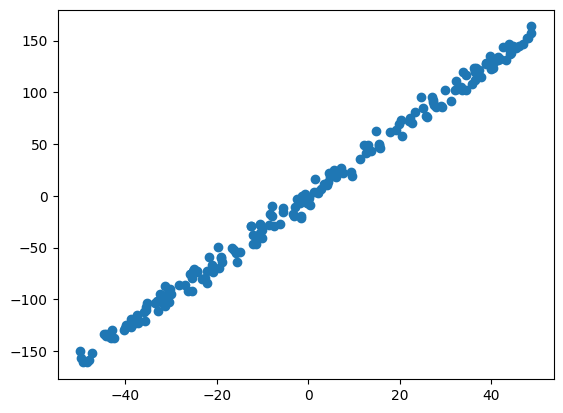

In [210]:

vi_linear = bnn.MeanGaussianStdGammaLinear(in_features=1,
                                           out_features=1,
                                           prior_m_weight=torch.Tensor([[0]]),
                                           prior_s_weight=torch.Tensor([[1e-5]]),
                                           bias=False,
                                           n_latent=1000)

N = 200

X = np.random.uniform(low=-50, high=50, size=(N, 1))
T = 3.2*X + np.random.normal(size=(N, 1), scale=5.5)

plt.scatter(X,T)

In [171]:
print(vi_linear.sampled_weight)
print(vi_linear.m_weight)
print(vi_linear.s_weight.pow(2))

print(" -  - ")

print(vi_linear.sampled_weight)
print(vi_linear.prior_m_weight)
print(vi_linear.prior_s_weight.pow(2))



sampled_w = torch.Tensor([[3]])
prior_m_w = torch.Tensor([[3]])
prior_s_w = torch.Tensor([[[3]]])
print("---")
print("multivar",get_log_gaussian_multivar(sampled_w, prior_m_w, prior_s_w))
print("log_norm",log_norm(sampled_w,prior_m_w,torch.sqrt(prior_s_w)))

print('torch.linalg.det(_cov_matrix)',torch.linalg.det(prior_s_w) )

k = 1
det_cov = prior_s_w
manual_res = -k/2*torch.log(torch.Tensor([2*torch.pi]))-1/2*torch.log(det_cov) - (1/(2*(prior_s_w**2)) * (sampled_w - prior_m_w)**2)
print("manual",manual_res)

None
Parameter containing:
tensor([[[0.4482]]], requires_grad=True)
tensor([[[1.6943]]], grad_fn=<PowBackward0>)
 -  - 
None
tensor([[[0.]]])
tensor([[[1.0000e-10]]])
---
mu.size() torch.Size([1, 1])
x.size() torch.Size([1, 1])
cov_matrix.size() torch.Size([1, 1, 1])
_cov_matrix.size() torch.Size([1, 1, 1])
det_cov_matrix tensor([3.])
1/2*torch.log(det_cov_matrix) tensor([0.5493])
multivar tensor([-1.4682])
log_norm tensor([[[-1.4682]]])
torch.linalg.det(_cov_matrix) tensor([3.])
manual tensor([[[-1.4682]]])


MAE =  tensor(88.1983, grad_fn=<MeanBackward0>)
[[[-0.30731994]]] [[[0.05945915]]] [[[0.5231898]]]
MAE =  tensor(5.0507, grad_fn=<MeanBackward0>)
[[[1.6405259]]] [[[1.9547061]]] [[[4.3561625]]]
MAE =  tensor(4.8981, grad_fn=<MeanBackward0>)
[[[1.6645706]]] [[[1.9021809]]] [[[4.1668415]]]
MAE =  tensor(4.8953, grad_fn=<MeanBackward0>)
[[[1.7134043]]] [[[1.8353637]]] [[[3.9338775]]]
MAE =  tensor(5.0877, grad_fn=<MeanBackward0>)
[[[1.749813]]] [[[1.7270899]]] [[[3.5748942]]]
MAE =  tensor(4.9455, grad_fn=<MeanBackward0>)
[[[1.8261214]]] [[[1.6638792]]] [[[3.3757837]]]
MAE =  tensor(4.9060, grad_fn=<MeanBackward0>)
[[[1.9084901]]] [[[1.5823855]]] [[[3.1303055]]]
MAE =  tensor(5.1057, grad_fn=<MeanBackward0>)
[[[2.0126674]]] [[[1.520757]]] [[[2.9529521]]]
MAE =  tensor(4.8924, grad_fn=<MeanBackward0>)
[[[2.053056]]] [[[1.3894534]]] [[[2.598434]]]
MAE =  tensor(4.9007, grad_fn=<MeanBackward0>)
[[[2.155301]]] [[[1.2725441]]] [[[2.3088694]]]
MAE =  tensor(4.9141, grad_fn=<MeanBackward0>)
[[[2

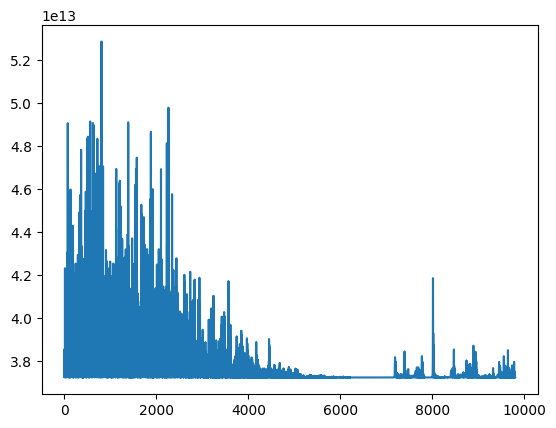

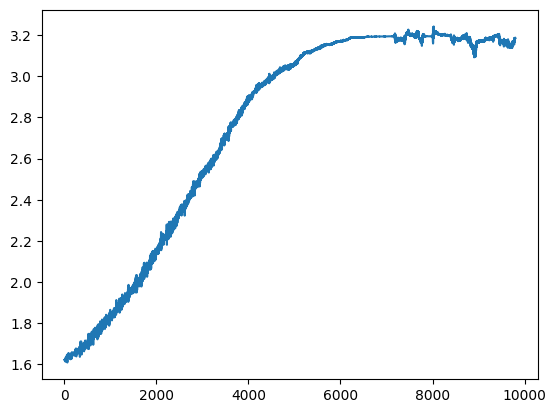

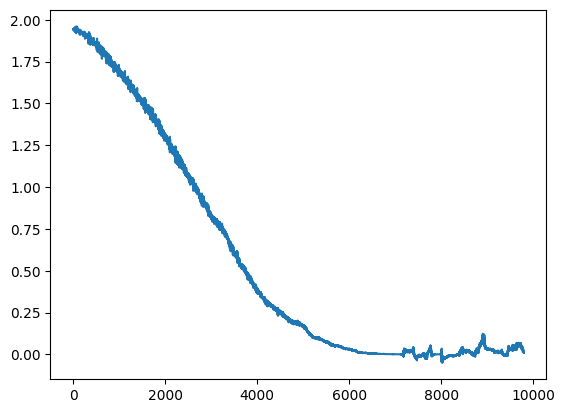

In [211]:
from torch.autograd import Variable

optimizer = torch.optim.Adam(vi_linear.parameters(),lr=0.2)
x = Variable(torch.Tensor(X), requires_grad=False) 
t = Variable(torch.Tensor(T), requires_grad=False)

history = {"loss":[],"m_weight":[],"s_weight":[]}
for i in range(10000):
    loss = loss_function(vi_linear, x, t)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

    history["loss"].append(loss.detach().numpy().copy().squeeze())
    history["m_weight"].append(vi_linear.m_weight.data.numpy().copy().squeeze())
    history["s_weight"].append(vi_linear.s_weight.data.numpy().copy().squeeze())
    if i % 250 ==0:
        preds = vi_linear.forward(x,stochastic=True)
        MAE = torch.nn.L1Loss()(preds,t)
        print("MAE = ", MAE)
        print(vi_linear.m_weight.data.numpy(),vi_linear.s_weight.data.numpy(), (torch.nn.Softplus()(vi_linear.s_weight).data**2).numpy())

plt.plot(history["loss"][200:])
plt.show()

plt.plot(history["m_weight"][200:])
plt.show()

plt.plot(history["s_weight"][200:])
plt.show()

In [212]:
torch.argmin(torch.Tensor([torch.Tensor(history["loss"][i]) for i in range(len(history["loss"]))]))

tensor(6508)

In [214]:
torch.nn.Softplus()(torch.Tensor(history["s_weight"][6508]))**2

tensor(0.4869)

In [206]:
analytical_posterior_var = ((1/5.5**2)*X.T@ X +1)**(-1)
print(analytical_posterior_var)

analytical_posterior_mean = analytical_posterior_var*(0.9+((1/5.5**2)*X.T @ T))
print(analytical_posterior_mean)

[[0.0001751]]
[[3.19023916]]


In [207]:
vi_linear.m_weight.data.numpy(), torch.nn.Softplus()(vi_linear.s_weight).data.numpy()**2

(array([[[3.1947966]]], dtype=float32), array([[[0.4793474]]], dtype=float32))

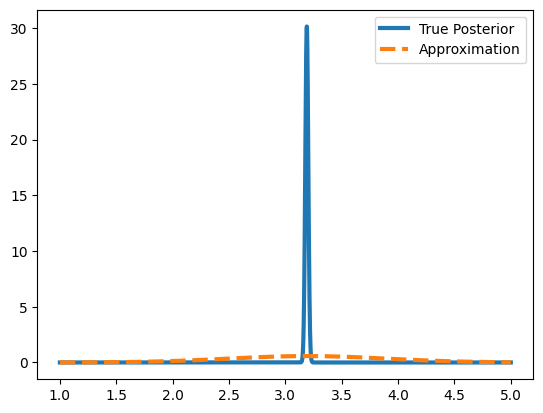

In [208]:
from scipy.stats import norm
xn = np.arange(1, 5, 0.0001)
true_dist = norm(loc = analytical_posterior_mean, 
                 scale = (analytical_posterior_var)**0.5)
q_dist = norm(loc = vi_linear.m_weight.data.numpy(), scale = torch.nn.Softplus()(vi_linear.s_weight).data.numpy())
plt.plot(xn, true_dist.pdf(xn).ravel(), linewidth=3, label="True Posterior")
plt.plot(xn, q_dist.pdf(xn).ravel(), '--', linewidth=3,label="Approximation")
plt.legend()

In [142]:
A,B = torch.randn([4,3,2]), torch.randn([2,4])
dist = torch.einsum("kij,jk -> ki", A,B)
print(dist)

res = []
for k in range(A.size(0)):
    res_i = []
    for i in range(A.size(1)):
        v = 0
        for j in range(A.size(2)):
            v += A[k,i,j]*B[j,k]
        res_i.append(v)
    res.append(res_i)
print(torch.Tensor(res))


tensor([[ 1.8111,  3.1902, -0.4879],
        [-1.0542, -0.3711, -0.5265],
        [ 2.0518,  0.4982, -1.6568],
        [-0.2799,  0.2558, -0.6402]])
tensor([[ 1.8111,  3.1902, -0.4879],
        [-1.0542, -0.3711, -0.5265],
        [ 2.0518,  0.4982, -1.6568],
        [-0.2799,  0.2558, -0.6402]])


In [132]:
A = torch.randn(2, 3, 4, 4)  # Batch of matrices
Ainv = torch.linalg.inv(A)
print(Ainv.size())
print((A @ Ainv).size())
torch.dist(A @ Ainv, torch.eye(4))

torch.Size([2, 3, 4, 4])
torch.Size([2, 3, 4, 4])


tensor(3.9718e-06)

In [6]:
import pandas as pd

pd.DataFrame(torch.eye(4),columns=["a","b","c","d"])

,a,b,c,d
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0


In [22]:
import src.models.gnn_layers as gnn_layers

src_content_mask = torch.Tensor([True,True]).to(torch.bool)
src_edge_mask = torch.Tensor([False,False]).to(torch.bool)
dst_mask = torch.Tensor([False,False]).to(torch.bool)

module = gnn_layers.MyBGATConv(in_channels=(2,2),
            out_channels=1,
            heads=1,
            negative_slope=0.0,
            add_self_loops=False,
            edge_dim=1,
            dropout=0.0,
            src_content_mask=src_content_mask,
            src_edge_mask=src_edge_mask,
            dst_content_mask=dst_mask,
            dst_edge_mask=dst_mask)
x = torch.randn(10,2)
edge_index = torch.tensor([[0,1,2],[0,1,2]])
edge_attr = torch.randn(3,1)

module(x,edge_index,edge_attr)

print("DESCRIPTION 2")
module.get_description_parameters()

src_content_in_channels 2
dst_content_in_channels 0
DESCRIPTION 2


,src_content_mean_0,src_content_mean_1,src_content_std_0,src_content_std_1,att_src_edge_0,src_edge_mean_0,src_edge_std_0,full_src_edge_mean_0,full_src_edge_std_0,dst_content_mean_0,...,dst_edge_mean_0,dst_edge_std_0,full_dst_edge_mean_0,full_dst_edge_std_0,att_edge_0,edge_mean_0,edge_std_0,full_edge_mean_0,full_edge_std_0,bias_0
0,0.150226,-2.450326,-0.332209,-0.890787,1.0,None,None,None,None,None,...,None,None,None,None,1.0,-0.215801,-0.814469,-0.215801,-0.814469,0.0


In [49]:
pd.read_csv("src/experiments/results/model_pipeline_content-liking_edge-sim_epochs-10000.csv")

,participant,min_train_loss,min_train_mae,init_src_content_0,trained_src_content_0,init_src_content_1,trained_src_content_1,init_att_src_edge_0,trained_att_src_edge_0,init_src_edge_0,...,init_full_dst_edge_0,trained_full_dst_edge_0,init_att_edge_0,trained_att_edge_0,init_edge_0,trained_edge_0,init_full_edge_0,trained_full_edge_0,init_bias_0,trained_bias_0
0,1,0.000136,0.009805,-1.264454,-38.784126,-0.357057,-41.020489,1.0,1.0,NaN,...,NaN,NaN,1.0,1.0,0.872724,-0.026633,0.872724,-0.026633,NaN,NaN


In [3]:
from src.models.gnn_layers import MyBGATConv
from src.models.bnn_layers import VIModule

model = MyBGATConv(
    in_channels=(1,1),
    out_channels=1,
    negative_slope=0,
    add_self_loops=False,
    edge_dim=2,
    src_content_mask=torch.Tensor([True]).to(torch.bool),
    src_edge_mask=torch.Tensor([True]).to(torch.bool),
    dst_content_mask=torch.Tensor([False]).to(torch.bool),
    dst_edge_mask=torch.Tensor([False]).to(torch.bool)
)

src_content_in_channels 1
dst_content_in_channels 0
src_content_in_channels 1
dst_content_in_channels 0
MeanFieldGaussianFeedForward(
in_features:1,
out_features:1,
n_latent:1,
softplus:Softplus(beta=1.0, threshold=20.0),
device:cpu) Parameter containing:
tensor([[-0.4493]], requires_grad=True) Parameter containing:
tensor([[0.7428]], requires_grad=True)


In [4]:
for m in model.children():
    print(m)
    print(isinstance(m,VIModule))
    print()

model._internal_losses

model.eval_losses()
model.eval_all_losses() # need a forward before to sample

SumAggregation()
False

Linear(1, 1, bias=False)
False

Linear(1, 1, bias=False)
False

MeanFieldGaussianFeedForward(
in_features:2,
out_features:1,
n_latent:1,
softplus:Softplus(beta=1.0, threshold=20.0),
device:cpu)
True

MeanFieldGaussianFeedForward(
in_features:1,
out_features:1,
n_latent:1,
softplus:Softplus(beta=1.0, threshold=20.0),
device:cpu)
True

MeanFieldGaussianFeedForward(
in_features:0,
out_features:1,
n_latent:1,
softplus:Softplus(beta=1.0, threshold=20.0),
device:cpu)
True

MeanFieldGaussianFeedForward(
in_features:1,
out_features:1,
n_latent:1,
softplus:Softplus(beta=1.0, threshold=20.0),
device:cpu)
True

MeanFieldGaussianFeedForward(
in_features:0,
out_features:1,
n_latent:1,
softplus:Softplus(beta=1.0, threshold=20.0),
device:cpu)
True



AttributeError: 'MeanFieldGaussianFeedForward' object has no attribute 'sampled_weights'

In [6]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[1.]]])
Parameter containing:
tensor([[[1.]]])
Parameter containing:
tensor([[[1.]]])
Parameter containing:
tensor([0.], requires_grad=True)
Parameter containing:
tensor([[-1.5873]], requires_grad=True)
Parameter containing:
tensor([[-0.2047]], requires_grad=True)
Parameter containing:
tensor([[0.5435],
        [1.9920]], requires_grad=True)
Parameter containing:
tensor([[0.1131],
        [1.0069]], requires_grad=True)
Parameter containing:
tensor([[0.6386]], requires_grad=True)
Parameter containing:
tensor([[-0.4440]], requires_grad=True)
Parameter containing:
tensor([], size=(0, 1), requires_grad=True)
Parameter containing:
tensor([], size=(0, 1), requires_grad=True)
Parameter containing:
tensor([[-0.4493]], requires_grad=True)
Parameter containing:
tensor([[0.7428]], requires_grad=True)
Parameter containing:
tensor([], size=(0, 1), requires_grad=True)
Parameter containing:
tensor([], size=(0, 1), requires_grad=True)


In [1]:
import numpy as np

In [23]:
import src.models.gnn_layers as gnn_layers
import torch

src_content_mask = torch.Tensor([True]).to(torch.bool)
src_edge_mask = torch.Tensor([False]).to(torch.bool)
dst_content_mask = torch.Tensor([False]).to(torch.bool)
dst_edge_mask = torch.Tensor([False]).to(torch.bool)
my_module = gnn_layers.MyGATConv(
    in_channels=(1,1),
    out_channels=1,
    heads=1,
    negative_slope=0.0,
    add_self_loops=False,
    edge_dim=1,
    dropout=0.0,
    bias=False,
    src_content_mask=src_content_mask,
    src_edge_mask=src_edge_mask,
    dst_content_mask=dst_content_mask,
    dst_edge_mask=dst_edge_mask,
    src_content_require_grad=False,
    src_content_weight_initializer="ones")

for i in my_module.children():
    print(i,isinstance(i,torch.nn.Module),hasattr(i,"weight"))
    if hasattr(i,"weight"):
        print("weight:",i.weight)

SumAggregation() True False
myLinear(1, 1, bias=False) True True
weight: Parameter containing:
tensor([[-1.1547]], requires_grad=True)
myLinear(0, 1, bias=False) True True
weight: <UninitializedParameter>
myLinear(0, 1, bias=False) True True
weight: <UninitializedParameter>
myLinear(1, 1, bias=False) True True
weight: Parameter containing:
tensor([[1.]])
myLinear(0, 1, bias=False) True True
weight: <UninitializedParameter>


In [24]:
import src.models.utils.weight_constrainers as wc

#wc.WeightClipper(0,.5)(my_module)
wc.WeightSigmoid(-1,1)(my_module)

print("end")
for i in my_module.children():
    print(i,isinstance(i,torch.nn.Module),hasattr(i,"weight"))
    if hasattr(i,"weight"):
        print("weight:",i.weight,i.weight.requires_grad)

end
SumAggregation() True False
myLinear(1, 1, bias=False) True True
weight: Parameter containing:
tensor([[-0.5207]], requires_grad=True) True
myLinear(0, 1, bias=False) True True
weight: <UninitializedParameter> True
myLinear(0, 1, bias=False) True True
weight: <UninitializedParameter> True
myLinear(1, 1, bias=False) True True
weight: Parameter containing:
tensor([[0.4621]]) False
myLinear(0, 1, bias=False) True True
weight: <UninitializedParameter> True


In [ ]:
x = ["apple", "banana", "cherry"]
print(str(x))


del x[0], x[1]

print(x)

['apple', 'banana', 'cherry']
['banana']


In [6]:
import pandas as pd

pd.DataFrame(columns=["a","b"]).drop(["a"],axis=1)

,b


In [6]:
import torch
def is_greater_0(x):
    return x > 0

variable_name = "experience" 

feature_names = ["liking","experience^2","experience","liking^2"]
X = torch.Tensor([[0,1,2,3,4],
                  [1,2,4,5,6],
                  [1,1,1,1,1],
                  [3,4,2,3,2]])

def locate_in_list(var,list):
    for i in range(len(list)):
        if var == list[i]:
            return i
    return None

print(X[:,locate_in_list("experience",feature_names)])


tensor([2., 4., 1., 2.])


In [ ]:
import pandas as pd

dfx = pd.DataFrame(X,columns=["a","b","c","d","e"])

dfx

,a,b,c,d,e
0,0.0,1.0,2.0,3.0,4.0
1,1.0,2.0,4.0,5.0,6.0
2,1.0,1.0,1.0,1.0,1.0
3,3.0,4.0,2.0,3.0,2.0


In [19]:
feature_name = "a"

mask = torch.zeros(len(dfx),dtype=torch.bool)
mask[dfx[feature_name]<=1] = True
mask

tensor([ True,  True,  True, False])

In [ ]:
def apply(mask:torch.Tensor):
    """
    Takes the truth values of the mask and parcelates it. Create a n_partition partition

    Parameters
    ----------
    mask : torch.Tensor

    Returns
    -------
    train_val_sets : list[Tuple[torch.Tensor,torch.Tensor]]
    """
    mask1 = torch.where(mask)[0]
        
    return mask1

print(apply(torch.Tensor([False,True,False,False,True])))

tensor([1, 4])


In [ ]:
mask = torch.Tensor([True,True,False,False,True])
torch.multinomial(mask, min(4,int(mask.sum())), replacement=False)

tensor([4, 1])

In [29]:
mask.sum()

tensor(2.)